# 1. Loading im.db as pd.df

In [3]:
import pandas as pd
import sqlite3

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline


In [4]:
conn = sqlite3.connect('data/im.db')
cursor = conn.cursor()

In [5]:
imdb_basics = pd.read_sql('''
SELECT *
FROM movie_basics
''', conn)

imdb_akas = pd.read_sql('''
SELECT *
FROM movie_akas
WHERE region = 'US'
GROUP BY movie_id
''', conn)

imdb_ratings = pd.read_sql('''
SELECT *
FROM movie_ratings
''', conn)

# 2. Name of df Variables:

### imdb Variables (each variable is an individual table):
- imdb_basics
- imdb_akas
- imdb_ratings

# 3. Merging IMDB

In [6]:
akas_basics_merge = imdb_akas.merge(imdb_basics, on='movie_id',
                                        how='inner')
imdb_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [7]:
imdb_merged = akas_basics_merge.merge(imdb_ratings, on='movie_id',
                                       how='left')
imdb_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47433 entries, 0 to 47432
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           47433 non-null  object 
 1   ordering           47433 non-null  int64  
 2   title              47433 non-null  object 
 3   region             47433 non-null  object 
 4   language           325 non-null    object 
 5   types              4977 non-null   object 
 6   attributes         1652 non-null   object 
 7   is_original_title  47428 non-null  float64
 8   primary_title      47433 non-null  object 
 9   original_title     47432 non-null  object 
 10  start_year         47433 non-null  int64  
 11  runtime_minutes    39673 non-null  float64
 12  genres             46840 non-null  object 
 13  averagerating      26654 non-null  float64
 14  numvotes           26654 non-null  float64
dtypes: float64(4), int64(2), object(9)
memory usage: 5.8+ MB


# 4. Cleaning tn.movie_budgets for merge

In [8]:
tn_budgets = pd.read_csv('data/tn.movie_budgets.csv.gz')

In [9]:
tn_budgets.drop_duplicates(subset = ['movie'], inplace=True)

In [10]:
tn_budgets.rename(columns = {'movie':'primary_title'}, inplace=True)

In [11]:
#Creating new coumn called year that is date.time
tn_budgets['Release_Date_Time'] = pd.to_datetime(tn_budgets['release_date'])
tn_budgets['start_year'] = tn_budgets['Release_Date_Time'].dt.year
tn_budgets['month'] = tn_budgets['Release_Date_Time'].dt.month

# 5: MERGE Merging Budgets to IMDB

#### Also changing columns to match Anat and Keanan

In [12]:
imdb_merged.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0069049,2,The Other Side of the Wind,US,None,imdbDisplay,None,0.0,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0
1,tt0112502,1,Bigfoot,US,None,None,None,0.0,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller",4.1,32.0
2,tt0159369,3,Cooper and Hemingway: The True Gen,US,None,None,None,0.0,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,2013,180.0,Documentary,7.6,53.0
3,tt0192528,1,Heaven & Hell,US,None,imdbDisplay,None,0.0,Heaven & Hell,Reverse Heaven,2018,104.0,Drama,4.0,72.0
4,tt0230212,1,The Final Journey,US,None,None,None,0.0,The Final Journey,The Final Journey,2010,120.0,Drama,8.8,8.0


In [13]:
full_movies_df = imdb_merged.merge(tn_budgets, on= ['primary_title','start_year'], how= 'inner')

In [14]:
full_movies_df['worldwide_gross'] = full_movies_df['worldwide_gross'].str.replace('$','').str.replace(',','').astype(float)
full_movies_df['production_budget'] = full_movies_df['production_budget'].str.replace('$','').str.replace(',','').astype(float)
full_movies_df['domestic_gross'] = full_movies_df['domestic_gross'].str.replace('$','').str.replace(',','').astype(float)

In [15]:
full_movies_df.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title,primary_title,original_title,...,genres,averagerating,numvotes,id,release_date,production_budget,domestic_gross,worldwide_gross,Release_Date_Time,month
0,tt0249516,2,Foodfight!,US,None,None,None,0.0,Foodfight!,Foodfight!,...,"Action,Animation,Comedy",1.9,8248.0,26,"Dec 31, 2012",45000000.0,0.0,7.370600e+04,2012-12-31,12
1,tt0359950,25,The Secret Life of Walter Mitty,US,None,imdbDisplay,None,0.0,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,...,"Adventure,Comedy,Drama",7.3,275300.0,37,"Dec 25, 2013",91000000.0,58236838.0,1.878612e+08,2013-12-25,12
2,tt0365907,20,A Walk Among the Tombstones,US,None,None,None,0.0,A Walk Among the Tombstones,A Walk Among the Tombstones,...,"Action,Crime,Drama",6.5,105116.0,67,"Sep 19, 2014",28000000.0,26017685.0,6.210859e+07,2014-09-19,9
3,tt0369610,21,Jurassic World 3D,US,None,None,3-D version,0.0,Jurassic World,Jurassic World,...,"Action,Adventure,Sci-Fi",7.0,539338.0,34,"Jun 12, 2015",215000000.0,652270625.0,1.648855e+09,2015-06-12,6
4,tt0376136,16,Hunter S. Thompson's The Rum Diary,US,None,working,None,0.0,The Rum Diary,The Rum Diary,...,"Comedy,Drama",6.2,94787.0,16,"Oct 28, 2011",45000000.0,13109815.0,2.154473e+07,2011-10-28,10


# Analysis:
# Trends in Genre
In order to get a better picture of how genre effects worldwide gross I needed to isolate individual genres so that I could apply a central tendancy to the 'worldwide_gross' of each genre and plot the results to show the average best performing genres.

The plot shows that Animation, Adventure, and Sci-FI are, on average, the highest performing genres and will typically generate the highest revenue. This does not show the whole picture for genres. To understand the actual highest performing genres we have to look at the 'actual' genres of movies that are most often a mix of different genres

So the 'actual' top genres are or include a mix of Adventure, Animation, and Sci-Fi and basedd on the results of 'actual' genres you'll want to use a combination of atleast two of the top 3 genres.

In [16]:
#converting dataset to SQL to filter/drop columns easily
full_movies_sql = full_movies_df.to_sql('genres', conn, if_exists='replace', index = False)

In [17]:
#Using tables that are unique and useful
full_movies = pd.read_sql('''
SELECT movie_id, primary_title, genres, start_year, runtime_minutes,
        averagerating, numvotes, production_budget, worldwide_gross
FROM genres 
''', conn)

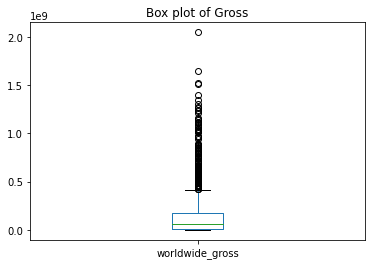

In [18]:
#boxplot of 'worldwide_gross' to find the best measure of central tendency
full_movies["worldwide_gross"].plot(kind="box", title="Box plot of Gross")
plt.show()

In [19]:
full_movies['genres'].value_counts()

Adventure,Animation,Comedy     65
Action,Adventure,Sci-Fi        52
Comedy                         51
Drama                          49
Comedy,Drama,Romance           49
                               ..
Adventure,Drama,History         1
Action,Comedy,Documentary       1
Biography,Documentary,Music     1
Animation,Family                1
Comedy,Crime,Romance            1
Name: genres, Length: 217, dtype: int64

### Splitting genres column to isolate individual genres

In [20]:
# spliting the genres column up so that each movie has an entry for each genre listed

genres = (full_movies.genres.str.split(',', expand=True)
            .stack()
            .to_frame(name='genres'))

genres.index = genres.index.droplevel(1)


In [21]:
# creating a new df by merging new columns back on the data set grouped by the median based off of box plot
genre_gross = (genres.join(full_movies.loc[:,['worldwide_gross']]).groupby('genres').median().sort_values('worldwide_gross', ascending=False))

In [22]:
#adding an index to new df because I don't know how to graph using the index as the x-axis
genre_gross_df = genre_gross.reset_index()

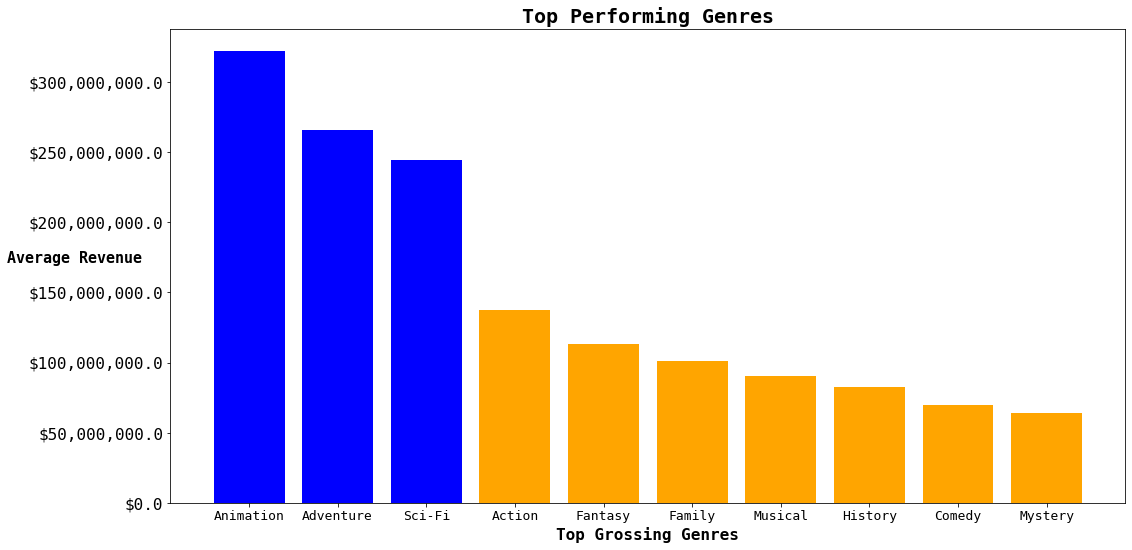

In [23]:


plt.rcParams['font.family'] = 'monospace'

x = genre_gross_df['genres'].head(10)
height= genre_gross_df['worldwide_gross'].head(10)
fig, ax = plt.subplots(figsize=(16,8))


color=['blue', 'blue', 'blue', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']
ax.bar(x=x, height=height, color=color)


plt.title("Top Performing Genres", fontsize=20, loc='center', weight='bold')
ax.set_xlabel('Top Grossing Genres', fontsize=16, weight='bold')

ax.set_ylabel('Average Revenue', fontsize=15, rotation=360, weight='bold', loc='center')
ax.ticklabel_format(style='plain', axis='y')

ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', labelsize=13)

ax.yaxis.set_label_coords(-0.1, 0.5)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))

plt.tight_layout(pad = 2.0)
plt.savefig('top_individual_genres.jpg', dpi=400)

### Using our top individual genres to find the 'actual' top genres

In [74]:
top_genres = pd.read_sql('''
SELECT title, movie_id, production_budget, worldwide_gross, month, genres
FROM genres
WHERE genres LIKE '%Adventure%Animation%' or genres LIKE '%Adventure%Sci-FI%'or genres LIKE '%Animation%Sci-FI%' or genres LIKE '%Adventure%Animation%Sci-FI%' 
or genres like '%Adventure%' or genres LIKE '%Animation%' or genres LIKE '%Sci-FI%'
ORDER BY worldwide_gross desc
''', conn)

In [75]:
top_10_full_genres = top_genres.groupby('genres')['worldwide_gross'].median().reset_index()
top_10_full_genres.columns = ['genres', 'median_gross']
top_10_full_genres.sort_values(by='median_gross', ascending=False, inplace=True)

In [82]:
top_10_full_genres.head(10)

,genres,median_gross
45,"Adventure,Fantasy",945577621.0
40,"Adventure,Drama,Sci-Fi",660825409.0
10,"Action,Adventure,Sci-Fi",560913841.0
1,"Action,Adventure,Animation",507064637.5
50,"Animation,Comedy,Family",469500298.0
47,"Adventure,Mystery,Sci-Fi",402448265.0
3,"Action,Adventure,Comedy",385851714.5
19,"Action,Sci-Fi",370541256.0
7,"Action,Adventure,Fantasy",349210715.0
18,"Action,Mystery,Sci-Fi",348319861.0


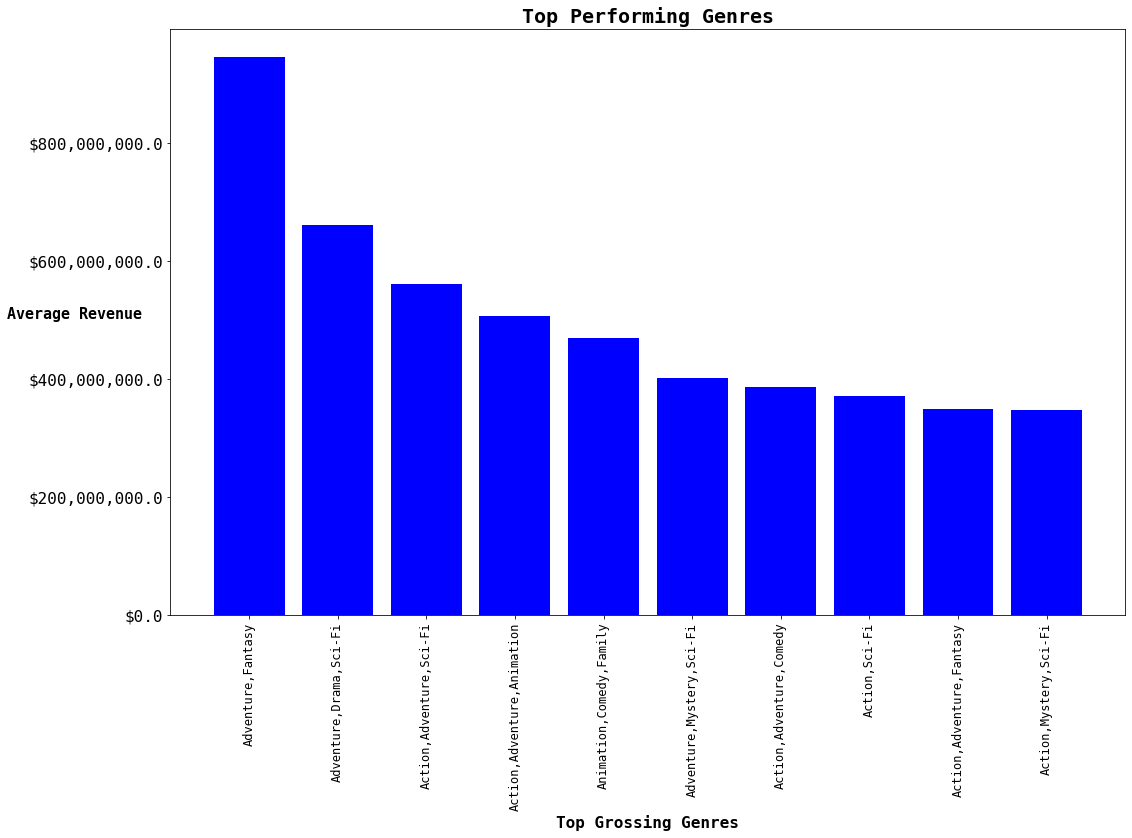

In [77]:
plt.rcParams['font.family'] = 'monospace'

x = top_10_full_genres['genres'].head(10)
height= top_10_full_genres['median_gross'].head(10)
fig, ax = plt.subplots(figsize=(16,12))



ax.bar(x=x, height=height, color='blue')


plt.title("Top Performing Genres", fontsize=20, loc='center', weight='bold')
ax.set_xlabel('Top Grossing Genres', fontsize=16, weight='bold')

ax.set_ylabel('Average Revenue', fontsize=15, rotation=360, weight='bold', loc='center')
ax.ticklabel_format(style='plain', axis='y')

ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', labelsize=12, rotation = 90)

ax.yaxis.set_label_coords(-0.1, 0.5)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))

plt.tight_layout(pad = 2.0)
plt.savefig('top_genres.jpg', dpi=400)

# Conclusions
This analysis leads to three recommendations for considering the best movie production concepts that will lead to a higher rate of success for Microsoft's new movie studiol

#### Set a budget for your movie of 65 million:
- Based on our analysis, we suggest aiming for a production budget greater than 65 million to increase the likelihood of higher worldwide gross revenues. Additionally, our analysis shows that the international market produces significantly more revenue than domestic markets, so it may be beneficial to focus on a worldwide market.

#### Release movies during the months of May to July and the month of November:
- The best time to release a movie would be during the summer months (May - July) and November. The summer months are ideal because all ages of school are off and people have more downtime to do activities such as seeing a movie. November also sees a high gross because it is when award show season begins to close and movies looking to receive awards try to release at the end of the season so they are at the top of people’s minds.

#### Create movies that are in the genre of 'Animated' 'Adventure' or 'Sci-Fi'
- Based on an analysis of worldwide gross by genre, it was found that Animation, Adventure and Sci-Fi are the highest performing genres on average. However, it’s important to note that the top-performing movies often include a mix of different genres. So for the best results in terms of revenue generation, it is recommended to use a combination of at least two of these top three genres: Adventure, Animation and Sci-Fi.

In [48]:
full_movies_sql_final = full_movies_df.to_sql('title', conn, if_exists='replace', index = False)

In [69]:
recomendation = pd.read_sql('''
SELECT title, movie_id, production_budget, worldwide_gross, month, genres
FROM genres
WHERE production_budget >= 65000000
                AND (genres LIKE '%Adventure%Animation%' or genres LIKE '%Adventure%Sci-FI%'
                or genres LIKE '%Animation%Sci-FI%' or genres LIKE '%Adventure%Animation%Sci-FI%')
                AND month >= 5 
                AND month <= 7
                or month == 11
ORDER BY worldwide_gross desc
''', conn)

In [70]:
recomendation

,title,movie_id,production_budget,worldwide_gross,month,genres
0,Jurassic World 3D,tt0369610,215000000.0,1.648855e+09,6,"Action,Adventure,Sci-Fi"
1,Group Hug,tt0848228,225000000.0,1.517936e+09,5,"Action,Adventure,Sci-Fi"
2,Marvel Avengers: Age of Ultron,tt2395427,330600000.0,1.403014e+09,5,"Action,Adventure,Sci-Fi"
3,Jurassic World: Fallen Kingdom,tt4881806,170000000.0,1.305773e+09,6,"Action,Adventure,Sci-Fi"
4,Frozen,tt2294629,150000000.0,1.272470e+09,11,"Adventure,Animation,Comedy"
...,...,...,...,...,...,...
175,Los cantos,tt1781935,17300.0,0.000000e+00,11,"Drama,Horror,Thriller"
176,Always Woodstock,tt1995477,2400000.0,0.000000e+00,11,"Comedy,Music,Romance"
177,The Final Girls,tt2118624,4500000.0,0.000000e+00,11,"Comedy,Drama,Fantasy"
178,#Horror,tt3526286,1500000.0,0.000000e+00,11,"Crime,Drama,Horror"


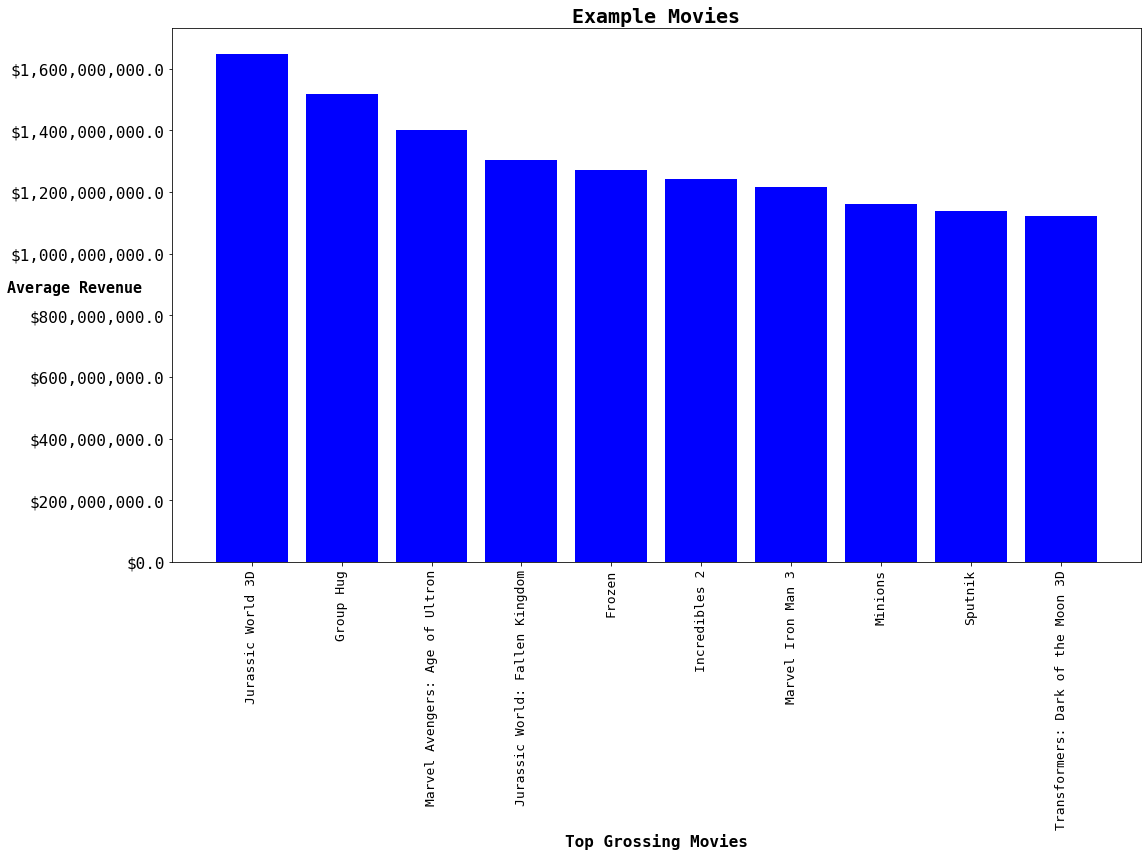

In [71]:
plt.rcParams['font.family'] = 'monospace'

x = recomendation['title'].head(10)
height= recomendation['worldwide_gross'].head(10)
fig, ax = plt.subplots(figsize=(16,12))



ax.bar(x=x, height=height, color= 'blue')


plt.title("Example Movies", fontsize=20, loc='center', weight='bold')
ax.set_xlabel('Top Grossing Movies', fontsize=16, weight='bold')

ax.set_ylabel('Average Revenue', fontsize=15, rotation=360, weight='bold', loc='center')
ax.ticklabel_format(style='plain', axis='y')

ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', labelsize=13, rotation = 90)

ax.yaxis.set_label_coords(-0.1, 0.5)
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))

plt.tight_layout()
plt.savefig('example_reccomendations.jpg', dpi=400)